In [2]:
from pettingzoo.butterfly import pistonball_v0
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import copy
from collections import defaultdict
from more_itertools import windowed
import tqdm
import itertools
np.random.seed(100)
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 8, 6

In [3]:
env = pistonball_v0.env(local_ratio=.02, continuous=False, random_drop=True,
starting_angular_momentum=True, ball_mass = .75, ball_friction=.3,
ball_elasticity=1.5, max_frames=900)

In [14]:
observation = env.reset()
for agent in env.agent_iter():
    reward, done, info = env.last()
    action = env.action_spaces
    observation = env.step(action)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [16]:
from pettingzoo.utils import random_demo
random_demo(env)

Total reward 0.0 done True


0.0

In [8]:
env.action_spaces

{'piston_0': Discrete(3),
 'piston_1': Discrete(3),
 'piston_2': Discrete(3),
 'piston_3': Discrete(3),
 'piston_4': Discrete(3),
 'piston_5': Discrete(3),
 'piston_6': Discrete(3),
 'piston_7': Discrete(3),
 'piston_8': Discrete(3),
 'piston_9': Discrete(3),
 'piston_10': Discrete(3),
 'piston_11': Discrete(3),
 'piston_12': Discrete(3),
 'piston_13': Discrete(3),
 'piston_14': Discrete(3),
 'piston_15': Discrete(3),
 'piston_16': Discrete(3),
 'piston_17': Discrete(3),
 'piston_18': Discrete(3),
 'piston_19': Discrete(3)}

In [4]:
def select_action_epsilon_greedy(Q_array, eps):
    
    if rnd.rand() < eps:
        num_actions = Q_array.shape[0]
        action = rnd.randint(num_actions)
        policy = np.full(fill_value=(1/num_actions),shape=Q_array.shape[0])
    else:
        actions_maximal = np.argwhere(Q_array == Q_array.max()).flatten()  # all maximal actions
        action = rnd.choice(actions_maximal)
        policy = np.zeros(Q_array.shape[0])
        policy[action] = 1 

    return action,policy

In [5]:
class LinearSchedule:
    def __init__(self, value_from, value_to, nsteps):
        self.value_from = value_from
        self.value_to = value_to
        self.nsteps = nsteps
        self.nums = np.linspace(self.value_from, self.value_to,self.nsteps)

    def value(self, step) -> float:
        
        
        if(step <= 0):
            step = 0
        elif(step>=self.nsteps-1):
            step = self.nsteps-1
        
        value = self.nums[step]
        return value

In [6]:
def sarsa(env, num_episodes, num_steps_max, alpha, gamma, exploration):
    """SARSA algorithm.
    """
    #Q = defaultdict(lambda: 0)
    Q = {}
    for agent in env.agents:
        Q[agent] = defaultdict(lambda: np.zeros(env.action_spaces[agent].n)) 
    returns = np.empty(num_episodes)
    lengths = np.empty(num_episodes, dtype=np.int)

    time_step = 0
    
    for i in tqdm.tnrange(num_episodes, desc='Episodes', leave=False):
        
        state = env.reset()
        for agent in env.agent_iter():
            eps = exploration.value(time_step)
            action,_ = select_action_epsilon_greedy(Q[agent][state.tobytes()],eps)
            G = 0
            for t in range(num_steps_max):

                reward, done, _ = env.last()
                next_state = env.step(action)
                G = gamma*G + reward
                eps = exploration.value(time_step)
                next_action,_ = select_action_epsilon_greedy(Q[agent][next_state.tobytes()],eps)

                # TD Update
                td_target = reward + gamma * Q[agent][next_state.tobytes()][next_action]
                td_delta = td_target - Q[agent][state.tobytes()][action]
                Q[agent][state.tobytes()][action] += alpha * td_delta
                time_step+=1
                if done:
                    break

                action = next_action
                state = next_state
            #print(f" {i} : {G}")
            returns[i] = G
            lengths[i] = t

    print(max(returns))
    return Q, returns, lengths

In [ ]:
num_runs, num_episodes, num_steps_max = 10, 500, 100

sarsa_fl_all = []
alpha_vals = [0.1]
gamma = 0.9
eps_vals = [(0.1,0.01)]
Q = {}
#q = defaultdict(lambda: np.zeros(env.action_spaces[agent].n))
for alpha in alpha_vals:
    for start,stop in eps_vals:
        returns_sarsa_fl = np.empty((num_runs, num_episodes))
        lengths_sarsa_fl = np.empty((num_runs, num_episodes), dtype=np.int)
        episode_schedule = LinearSchedule(start, stop, num_episodes*num_steps_max)
        for i in tqdm.tnrange(num_runs, desc='Runs'):
            q,returns_sarsa_fl[i],lengths_sarsa_fl[i] = sarsa(env, num_episodes, num_steps_max, alpha, gamma, episode_schedule)
        sarsa_fl_all.append((returns_sarsa_fl,lengths_sarsa_fl,alpha,start))

0.017020057306590265


In [97]:
observation = env.reset()
for agent in env.agent_iter():
    reward, done, info = env.last()
    observation = env.step(int(max(q[agent][observation.tobytes()])))

In [19]:
state = env.reset()
env.render()
while True:
    for agent in env.agent_iter():
        action = int(max(q[agent][state.tobytes()]))
        reward, done, info = env.last()
        state = env.step(action)
        env.render()

        if done:
            print("here")
            break
env.close()

KeyboardInterrupt: 

In [20]:
env.close()

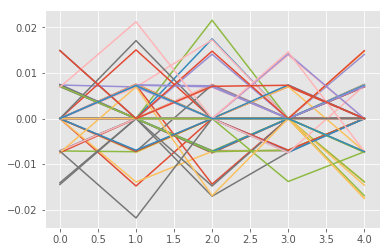

In [18]:
plt.plot(sarsa_fl_all[0][0])
plt.show()

In [8]:
sarsa_fl_all

[]